### Fit Arnett Radiation diffusion model to SNe Ia
#### Arnett 1982, Chatzopoulos 2012, Chatzopoulos 2013b
#### Update the code by changing the priors. study the effect of priors on MCMC 

[Priors](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

In [1]:
# Details of the object under study
# Also do this with DM = 33.82 +/- 0.27

Object = 'SN2011aa'
Host = 'PGC021381'
RA = '07:36:42.63'
DEC = '+74:26:34.80'
z = 0.01255
EB_V_Gal = 0.065              # Na ID around maximum (Turatto 2003)
EB_V_Host = 0.0               # Schlafly & Finkbeiner 2011
DM = 33.74 
DM_err = 0.27                 # modz  http://leda.univ-lyon1.fr/ledacat.cgi?o=PGC%20021381
JD_offset = 2455000   
B_maximum = 611.65

In [2]:
op_bolo_file = '/home/anirban/SN2011_Anirban/Bolometry/bolometry_optical.dat'

uv_op_bolo_file = '/home/anirban/SN2011_Anirban/Bolometry/bolometry_total.dat'

In [3]:
# imports
import os
import re
import glob
import warnings
import numpy as np
import pandas as pd
from astropy import units as u
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator

## import MCMC 

import emcee
import corner

## Parallelisation of emcee

from multiprocessing import Pool

# Plotting parameters
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

In [4]:
# Remove warnings 
#=============================================================================#

warnings.simplefilter('ignore')
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.reset_option('display.float_format')

#=============================================================================#


In [5]:
# =============================================================================#

# Fundamental Constants which will be used in the model (CGS units)
#--------------------------------------------------------------------------------#

M_sun = 1.989e33          # g
c = 2.99792458e10         # cm/sec
kappa = 0.10              # cm^2/g, kappa_optical 
beta = 13.8               # constant of intergration
v_ph = 5.4e8              # From the Si-II absorption minima at Maxima
M_ej = 1.00*M_sun         # g
E_k = 0.3*M_ej*v_ph**2    # erg

## Equation of tau_m
tau_m = ((2*kappa*M_ej)/(beta*c*v_ph))**0.5
tau_m_days = tau_m/86400.0
#print("Estimated Value of tau_m: %.3f in days"%tau_m_days)
#----------------------------------------------------------------------#

e_Ni = 3.90e10           # (erg/s/g) energy production in 1s by 1g of 56-Ni
e_Co = 6.78e9            # (erg/s/g) energy production in 1s by 1g of 56-Co
                 
tau_Ni = 760340.6        # e-folding time of 56-Ni (8.8 days)
tau_Co = 9685230.0       # e-folding time of 56-Co (111.3 days)
t_Ni = 8.8 
t_Co = 111.8
k_g = 0.03               # cm^2/g

#----------------------------------------------------------------------#
guess_Mni = 0.5          # in units of M_sun
guess_EK = 0.7           # In units of 10^51 erg (foe)
guess_Mej = 1.0          # In units of M_sun
guess_tr = 15            # rise-time in days
#----------------------------------------------------------------------#

In [108]:
## Plotting function

def plot_params(band, ax, ml_x, mil_x, ml_y, mil_y, s, invert=False):
    
    '''
    Remarks: Plotting parameters
    ax: axis object
    ml_x: major locator 'x'
    mil_x: minor locator 'x'
    ml_y: major locator 'y'
    mil_y: minor locator 'y'
    invert: Bool for the y-axis to be inverted 
    
    '''
    
    if invert:
        ax.invert_yaxis()
        
    ax.xaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', 
                   length = 16, width = 1.5, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', 
                   length = 8, width = 0.8, labelsize = 20)
    ax.xaxis.set_major_locator(MultipleLocator(ml_x))
    ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
    ax.yaxis.set_major_locator(MultipleLocator(ml_y))
    ax.yaxis.set_minor_locator(MultipleLocator(mil_y))
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = s)
    #tick.label1.set_fontweight('bold')
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = s)

        
def Rad_Diffusion(theta, jd_list): 
    
    '''
    Info: Fits the early part of the Light Curve.
    theta: array of fit-parameters.
    jd_list: list of jd from a clipped dataframe
    Returns: Luminosity (erg/s)
    Parameters to fit are the Nickel-56 mass, ejecta-mass and rise-time of
    the bolometric LC.
    m_ni = Nickel mass in terms of M_solar.
    t_d = effective LC timescale (the mean of the hydrodynamical and diffusion timescales.)
    (1-exp(-At^-2)) accounts for gamma-ray leakage, where large A means that all gamma-rays and
    positrons are trapped.
    jd_exp = time since explosion in jd. 
    '''
    
    from scipy.integrate import quad
    m_ni, t_d, t_g, jd_exp = theta
    
    phase_list = jd_list - jd_exp                        
    time_list = phase_list*86400.0                     
    
    tau_m = t_d * 86400
    
        
    x = time_list/tau_m
    y = tau_m/(2*tau_Ni)
    s = (tau_m*(tau_Co - tau_Ni)/(2*tau_Co*tau_Ni))
    
    def funcA(z, y):
        return 2*z*np.exp((-2*z*y)+z**2)
    def funcB(z, y, s):
        return 2*z*np.exp((-2*z*y)+(2*z*s)+(z**2))
     
    #for index, time in enumerate(x):
    #    lph[index] = M_sun*m_ni*np.exp(-time**2)*((e_Ni-e_Co)*quad(funcA, 0, time, args=(y,))[0]+ \
    #                                             e_Co*quad(funcB, 0, time, args=(y, s))[0])* \
    #                                              (1 - np.exp(A*))
    a = np.array([quad(funcA, 0, xi, args=(y,))[0] for xi in x])
    aerr = np.array([quad(funcA, 0, xi, args=(y,))[1] for xi in x])

    # integrate B(z)dz from 0 to x
    b = np.array([quad(funcB, 0, xi, args=(y, s))[0] for xi in x])
    berr = np.array([quad(funcB, 0, xi, args=(y, s))[1] for xi in x])
    
    try:
        lum = m_ni * M_sun * np.exp(-x**2) * ((e_Ni-e_Co)*a + e_Co*b) * (1 - np.exp(-t_g**2/phase_list**2))
    except ValueError:
        lum = -np.inf
    
    return lum

def log_likelihood(theta, x, y, y_err):
    
    param = theta
        
    lum = Rad_Diffusion(param, x)
    diff = y - lum
    sigma = y_err**2
    
    try:
        LnLike = -0.5*np.sum(diff**2/sigma)
    except ValueError:
        LnLike = -np.inf
    
    return LnLike


## Change the priors 
def log_prior(theta):
    
    m_ni, t_d, A, jd_exp = theta
    if m_ni > 0 and t_d > 0 and 2455590 < jd_exp < 2455595:
        try:
            return 0
        except ValueError:
            return -np.inf
    else:
        return -np.inf


def log_prob(theta, log_prior, x, y, y_err):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    try:
        value = lp+log_likelihood(theta, x, y, y_err)
    except ValueError:
        value = -np.inf
    
    #return lp + log_likelihood(theta, x, y, y_err)
    return value


def run_MCMC(log_prob, log_prior, soln, df, t, l, l_err, ndim, nwalkers, niter, progress=True):
    
    import emcee

    
    x = df[t].values
    y = df[l].values 
    y_err = df[l_err].values
    
    p0 = [soln + 1e-4*np.random.randn(ndim) for _ in range(nwalkers)]
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=([log_prior, x, y, y_err]), pool = pool)
        pos, prob, state = sampler.run_mcmc(p0, niter, progress=progress)
    
    return [sampler, pos, prob, state]

def run_walkers(sampler, put_label, axes, ndim):


    samples = sampler.get_chain()
    new_samples = sampler.flatchain
    labels = put_label
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "", alpha=0.3)
        #ax.plot(samples[i], 'k', alpha =0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    new_max = new_samples[np.argmax(sampler.flatlnprobability)]
    
    return new_max

def corner_plot(sampler, put_label, soln, ndim):
    
    import corner
    #samples = sampler.chain[:, :, :].reshape((-1, ndim))
    
    #m_ni = soln[0] # in M_solar
    #t_d = soln[1]  # in days
    #t_gamma = np.sqrt(soln[2])  # in days
    #t_RB = soln[3] - B_max     # in days
    samples = sampler[0].flatchain
    #m_ni = sampler[:, :, 0].reshape(-1)
    #t_d = samplesr[:, :, 1].reshape(-1)
    #t_g = np.sqrt(sampler[:, :, 2].reshape(-1))
    #t_RB = sampler[:, :, 3].reshape(-1) - B_maxnp.sqrt(np.diag(covar))
    
    #new_samples = np.vstack([m_ni, t_d, t_g, t_RB]).T
    
    fig = plt.figure(figsize=(15, 15))
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=50, direction='in', length=10, width=5)
        
    labels = put_label
    fig = corner.corner(samples, show_titles = True,
                   plot_datapoints = True, quantiles = [0.16, 0.5, 0.84], labels = labels,
                   title_kwargs = {'fontsize': 22, 'fontweight': 'bold'}, 
                   plot_contours = True, color='#7678ed', reverse=False, fig=fig,
                       labelpad=0.05)
    fig.subplots_adjust(wspace=0.1, hspace=0.15)

    
    #fig.savefig(save_results+'Corner.pdf', dpi=500, 
    #            bbox_inches='tight')

def results_MCMC(sampler, put_label,  params, ndim):
    
    from IPython.display import display, Math
    samples = sampler[0].flatchain
    param = params
    labels = put_label
    for i in range(len(param)):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))    
    
def run_minimizer(log_likelihood, df, x, y, y_err, param, seed):
    
    from scipy.optimize import minimize
    data = (df[x].values, df[y].values, df[y_err].values)
    np.random.seed(seed)
    nl1 = lambda *args: -log_likelihood(*args)
    initial = np.array(param)
    soln = minimize(nl1, initial, args = data)
    fit_values = soln.x    
    return fit_values

def cal_chisq(params, data_df):
    
    best_fit = Rad_Diffusion(params, data_df['JD'])
    chisq = np.sum((best_fit - data_df['Lum'])**2/data_df['Lum_Err']**2)
    
    return chisq        

In [81]:
op_bolo_df = pd.read_csv(op_bolo_file, sep='\s+', skiprows=18, engine='python')
op_bolo_df['LogLum_Err'] = 0.434 * (op_bolo_df['Lum_Err'] / op_bolo_df['Lum'])

In [26]:
uv_op_bolo_df = pd.read_csv(uv_op_bolo_file, sep='\s+', skiprows=19, engine='python')

In [27]:
op_bolo_df['JD'] = pd.to_numeric(op_bolo_df['JD'])
op_bolo_df['Lum'] = pd.to_numeric(op_bolo_df['Lum'])
op_bolo_df['Lum_Err'] = pd.to_numeric(op_bolo_df['Lum_Err'])
op_bolo_df = op_bolo_df[op_bolo_df['JD'] < 2455685]

In [28]:
# Ni mass, t_diff, t_gamma, jd_exp
param_quasi = [0.5, 15, 40, 2455590]
#bnds = ((0.1,1), (0.5,1.4), (10,20))
soln_early_quasi=run_minimizer(log_likelihood=log_likelihood, df=op_bolo_df, 
                               x='JD', y='Lum', y_err='Lum_Err', param=param_quasi, seed=42)
print (soln_early_quasi)

[6.49298840e-01 1.72653997e+01 6.22084252e+01 2.45559181e+06]


In [29]:
sampler_early_quasi = run_MCMC(log_prob, log_prior, soln_early_quasi, op_bolo_df, 
                               'JD', 'Lum', 'Lum_Err', 4, 50, 5000)

100%|██████████| 5000/5000 [44:39<00:00,  1.87it/s]


[6.49301998e-01 1.72654711e+01 6.22086704e+01 2.45559181e+06]


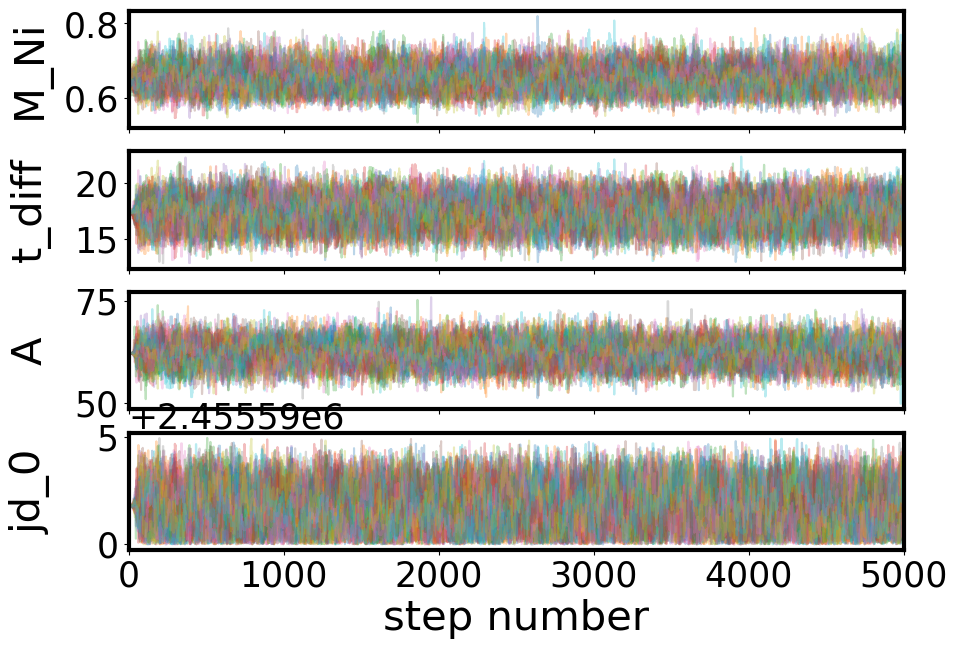

In [32]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)

put_label_walk = ['M_Ni', 't_diff', 'A', 'jd_0']
new_max_quasi = run_walkers(sampler_early_quasi[0], put_label_walk, axes, 4)
print (new_max_quasi)
plt.show();

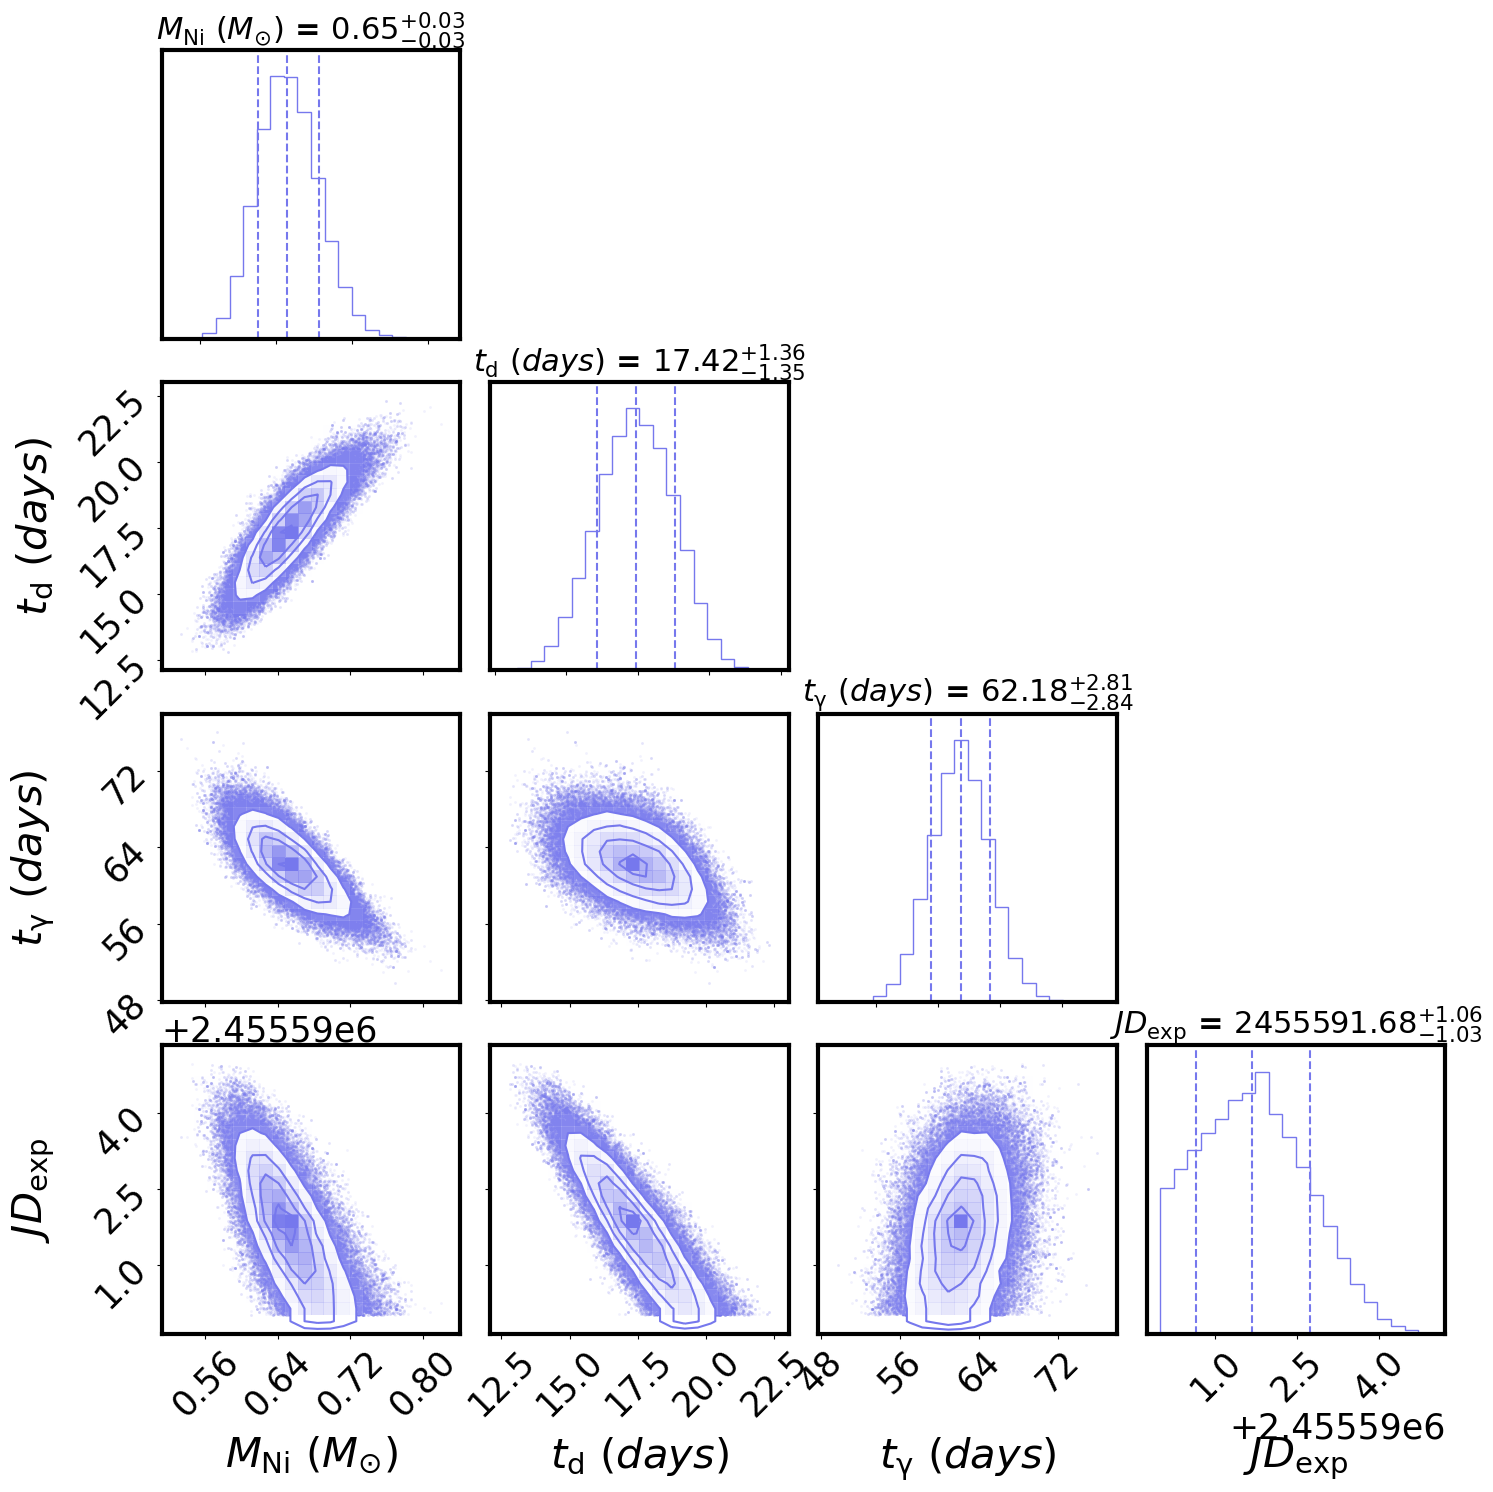

In [110]:
put_label_corn = [r'$M_{\rm Ni}\ (M_{\odot})$', r'$t_{\rm d}\ (days)$', r'$t_{\rm \gamma}\ (days)$', r'$JD_{\rm exp}$']

corner_plot(sampler_early_quasi, put_label_corn, soln_early_quasi, 4)
plt.savefig("/home/anirban/SN2011_Anirban/Plots/Bolometry_Corner.png", 
            dpi=200, bbox_inches='tight')

plt.show();

In [47]:
results_MCMC(sampler_early_quasi, put_label_corn, param_quasi, 4)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

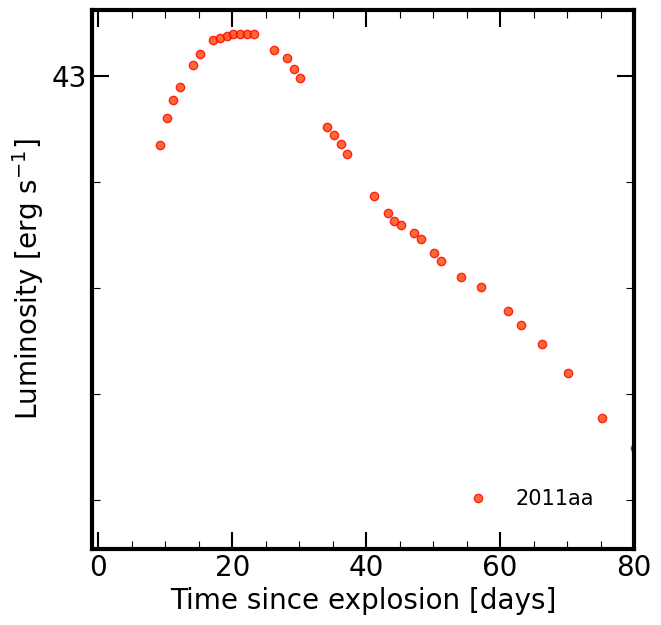

In [51]:
#time_since_exp_quasi = np.linspace(593, 800, 1000)
#lum_quasi = Rad_Diffusion(soln_early_quasi, time_since_exp_quasi)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plot_params('A', ax, ml_x = 20, mil_x = 5, ml_y = 1.0, mil_y = 0.2, s=10, invert=False)
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 1.5, labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 0.8, labelsize = 12)
legend_properties = {'size':15, 'weight':'book'}
ax.set_xlim(-1, 80)
#ax.set_ylim(40, 43.5)
#ax.plot(time_since_exp_quasi - soln_early_quasi[3], np.log10(lum_quasi), 'k--', linewidth=2, label='1-D Radiation Diffusion')
#ax.errorbar(clipped_lum_df['JD'] - soln_early[3], clipped_lum_df['Lum'], yerr=clipped_lum_df['Lum_Err'], 
#            fmt='', ms = 6, marker= 'o', c='orangered', mec = 'red', ls='', lw=0.7, capsize=2, capthick=1, label='2020sck',
#           alpha = 0.8)


ax.plot(op_bolo_df['JD'] - soln_early_quasi[3], np.log10(op_bolo_df['Lum']), 
            ms = 6, marker= 'o', c='orangered', mec = 'red', ls='', lw=0.7, label='2011aa',
           alpha = 0.8)
#ax.plot(lum_df_total['JD'] - soln_early[3], lum_df_total['Lum'], 'ro', label='Bolometry Data Points')
#ax.set_xlim(1, 30)
ax.set_xlabel('Time since explosion [days]', fontsize = 20)
ax.set_ylabel(r'Luminosity $[\rm erg\ s^{-1}]$', fontsize = 20)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
    
#ax.ticklabel_format(axis = 'y', useOffset=False, style='sci')

ax.legend(frameon= False, fancybox = False, shadow = True, framealpha=0.3, facecolor = 'white', 
         loc = 'lower right', prop = legend_properties, borderaxespad=1.5)

#chi_sq = cal_chisq(soln_early, lum_df_opt)
#print (chi_sq)


#ax.text(54, 1.2e43, r'$M_{Ni} = 0.61\ M_{\odot}$', fontsize=15);
#ax.text(54, 1.1e43, r'$t_{0} = 16.85\ d$', fontsize=15);
#ax.text(54, 1.0e43, r'$t_{\gamma} = 41.4\ d$', fontsize=15);
#ax.text(54, 0.9e43, r'$t_{d} = 13.38\ d$', fontsize=15);
#ax.text(54, 0.8e43, r'$\kappa = 0.11\ cm^{2}/g$', fontsize=15);
#ax.text(54, 0.7e43, r'$v = 9500\ km/s$', fontsize=15);
#ax.text(54, 0.6e43, r'$E_{k} = 0.65\ foe$', fontsize=15);
#ax.text(54, 0.5e43, r'$M_{ej} = 1.20\ M_{\odot}$', fontsize=15);
#ax.text(54, 0.38e43, r'$\chi^{2}/ \rm dof = 1.4$', fontsize=15);
#plt.savefig(save_results+"Bolometry_Arnett.png", dpi=500, bbox_inches='tight',
#           facecolor='white')


# In[101]:

plt.show()

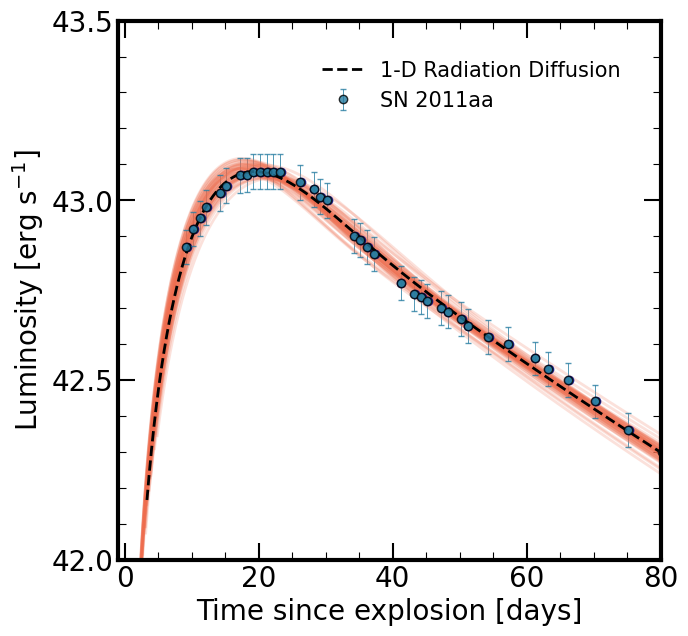

In [111]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plot_params('A', ax, ml_x = 20, mil_x = 5, ml_y = 0.5, mil_y = 0.1, s=10, invert=False)
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 1.5, labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 0.8, labelsize = 12)
legend_properties = {'size':15, 'weight':'book'}
ax.set_xlim(-1, 80)
ax.set_ylim(42.0, 43.5)

time = np.linspace(2455595, 2455690, 1000)

flat_samples = sampler_early_quasi[0].flatchain

ni_56 = np.percentile(flat_samples[:, 0], [50])
t_d = np.percentile(flat_samples[:, 1], [50])
t_y = np.percentile(flat_samples[:, 2], [50])
jd_exp = np.percentile(flat_samples[:, 3], [50])

final_results = [ni_56, t_d, t_y, jd_exp]

lum_final = Rad_Diffusion(final_results, time)


indices = np.random.randint(len(flat_samples), size=50)


for inds in indices:
    
    sample = flat_samples[inds]
    
    time_since_exp = time - sample[3]

    lum_quasi = Rad_Diffusion(sample, time)
    
    #print (lum_quasi)
    
    plt.plot(time_since_exp, np.log10(lum_quasi), alpha=0.2, color='#ee6c4d', linewidth=2)
    
    
ax.plot(op_bolo_df['JD'] - final_results[3], op_bolo_df['LogLum'], 
            ms = 6, marker= 'o', c='#277da1', mec = 'navy', ls='', lw=0.7,
           alpha = 0.8)    

ax.errorbar(op_bolo_df['JD'] - soln_early_quasi[3], op_bolo_df['LogLum'], yerr=op_bolo_df['LogLum_Err'], 
            fmt='', ms = 6, marker= 'o', c='#277da1', mec = 'black', ls='', lw=0.7, capsize=2, capthick=1,
           alpha = 0.8, label='SN 2011aa')

ax.plot(time - final_results[3], np.log10(lum_final), 'k--', linewidth=2, label='1-D Radiation Diffusion')


ax.legend(frameon= False, fancybox = False, shadow = True, framealpha=0.3, facecolor = 'white', 
         loc = 'upper right', prop = legend_properties, borderaxespad=1.5)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
    


ax.set_xlabel('Time since explosion [days]', fontsize = 20)
ax.set_ylabel(r'Luminosity $[\rm erg\ s^{-1}]$', fontsize = 20)

plt.savefig('/home/anirban/SN2011_Anirban/Plots/Rad_Diff_Opt.png', dpi=200, bbox_inches='tight')

plt.show()    


In [6]:
kappa = 0.10   # constant optical opacity (cm^2/g)
v_ph = 8.61e8   # velocity in cm/s
t_d = 17.42   # diffusion time in days
td_err_upper = 1.36
td_err_lower = 1.35
Mej = (0.5 * beta * c * v_ph * (t_d* 86400)**2)/kappa   # ejecta mass in gm
norm_Mej = (Mej/M_sun)     # ejecta mass in solar mass
normMej_err_upper = (2*norm_Mej*td_err_upper)/t_d
normMej_err_lower = (2*norm_Mej*td_err_lower)/t_d

EK = 0.3 * Mej * v_ph**2   # kinetic energy in erg/s
norm_EK = EK/10**51        # kinetic energy in foe
normEK_err_upper = (norm_EK*normMej_err_upper)/norm_Mej
normEK_err_lower = (norm_EK*normMej_err_lower)/norm_Mej
print ('#=======================================================#')
print ('The ejected mass is %f + %f - %f:'%(norm_Mej, normMej_err_upper, normMej_err_lower))
print ('The kinetic energy of explosion is %f + %f - %f:'%(norm_EK, 
                                                           normEK_err_upper, normEK_err_lower))
print ('The diffusion time is:', t_d)
print ('#=======================================================#')
print (beta)

#=======================================================#
The ejected mass is 2.028439 + 0.316725 - 0.314396:
The kinetic energy of explosion is 0.897272 + 0.140102 - 0.139072:
The diffusion time is: 17.42
#=======================================================#
13.8
